# Salt budget of the Atlantic

The aim is to put $M_{ov}$ into context.

The salt budget terms for a given ocean basin are:

\begin{align}
     \mathrm{change \, of \, basin \, salt \, content} & = \mathrm{advection \, into \, basin} + \mathrm{surface \, fluxes} \\
     \partial_t S & = S_{adv} (x) + (E - P - R) \\
     \partial_t S & = S_{adv} (x) + (E - P - R) \\
\end{align}

The salt advection across a zonal section at $x$ is
$$ S_{adv} (x) = \int \int v(x,y,z) S(x,y,z) \, \mathrm{d}y \, \mathrm{d}z$$

Similar to the freshwater budget terms we define the overturning and azonal salt transport components as follows:
$$ S_{ov} (x) = \int \bar{v}(x,z) \langle S(x,z) \rangle \, \mathrm{d}z $$
$$ S_{az} (x) = \int \overline{v' (x,z) S'(x,z)} \, \mathrm{d}z $$
where $\langle x \rangle$ is the zonal average, $\bar{x}$ is the zonal integral, and $x'$ the deviation from the zonal mean.

In [1]:
import os
import sys
import numpy as np
import xesmf as xe
import pickle
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
matplotlib.rc_file('rc_file_paper')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
from maps import add_cyclic_POP
from tqdm import notebook
from paths import path_results, path_prace, file_RMASK_ocn, file_RMASK_ocn_low, file_ex_ocn_ctrl, file_ex_ocn_lpd
from FW_budget import load_obj, lat_bands
from timeseries import IterateOutputCESM
from xr_DataArrays import xr_AREA, xr_DZ
from xr_regression import ocn_field_regression, xr_linear_trend

In [4]:
RMASK_ocn = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False).REGION_MASK
RMASK_low = xr.open_dataset(file_RMASK_ocn_low, decode_times=False).REGION_MASK

In [5]:
# to convert integral to average, divde by column height
DZT_HIGH_100m  = xr_DZ(domain='ocn').isel(z_t=slice(0,9)).sum('z_t')
DZT_HIGH_1000m = xr_DZ(domain='ocn').isel(z_t=slice(9,22)).sum('z_t')
DZT_LOW_100m   = xr_DZ(domain='ocn_low').isel(z_t=slice(0,10)).sum('z_t')
DZT_LOW_1000m  = xr_DZ(domain='ocn_low').isel(z_t=slice(10,40)).sum('z_t')

In [6]:
def regrid_rectangular(da):
    """ regrids to rectangular grid """
    assert 'lat' in da.coords
    assert 'lon' in da.coords
    target = xr.DataArray(coords={'lat':np.arange(89.5,-90,-1), 'lon':np.arange(-179.5,180,1)}, dims=['lat','lon'])
    regridder = xe.Regridder(da, target, 'nearest_s2d', reuse_weights=True, periodic=True)
    da_regridded = regridder(da)
    return da_regridded

Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_2400x3600_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: nearest_s2d_384x320_180x360_peri.nc


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


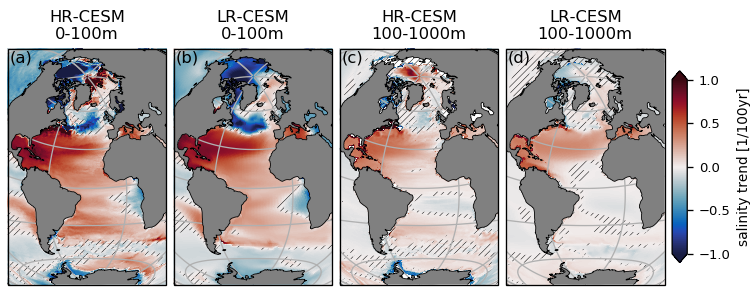

In [7]:
rn = {'TLAT':'lat', 'TLONG':'lon'}
drop = ['ULONG','ULAT']

f = plt.figure(figsize=(6.4,2.5), constrained_layout=False)
for k, run in enumerate(['rcp', 'lr1']):
#     if k>0:  continue
    RMASK = [RMASK_ocn, RMASK_low][k]
    for d, depth in notebook.tqdm(enumerate(['0-100m', '100-1000m'])):
        maxv = [1,1][d]
        DZT_int = [[DZT_HIGH_100m, DZT_HIGH_1000m], [DZT_LOW_100m, DZT_LOW_1000m]][k][d]
        stats = xr.open_dataset(f'{path_prace}/SALT/SALT_dz_{depth}_trend_stats_{run}.nc')
        stats['p_value'] = stats.p_value.where(RMASK>0)
        stats = stats.assign_coords({'TLAT':RMASK.TLAT, 'TLONG':RMASK.TLONG})
        j = k+2*d
        ax = f.add_axes([j*.22+.01,.01,.21,.85], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-30, central_latitude=20))
        ax.set_extent((-6e6, 3.5e6, -8.5e6, 1e7), crs=ccrs.LambertAzimuthalEqualArea())
        ax.set_title([f'HR-CESM\n{depth}', f'LR-CESM\n{depth}'][k])
        ax.text(.01,.94, '('+['a','b','c','d'][j]+')', transform=ax.transAxes)

        # trends
        da = add_cyclic_POP(stats.slope.where(RMASK>0)/DZT_int*100*365)
        im = ax.pcolormesh(da.TLONG, da.TLAT, da, transform=ccrs.PlateCarree(),
                           cmap='cmo.balance', vmin=-maxv, vmax=maxv)
        
        #hatches
        da = xr.where(np.isfinite(stats.p_value),stats.p_value,0).rename(rn).drop(drop)
        pvalue = regrid_rectangular(da)
        ax.contourf(pvalue.lon, pvalue.lat, pvalue, [0,0.05,1],
                    colors='none', hatches=[None,'//////'], transform=ccrs.PlateCarree())
        
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey', linewidth=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
        gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# colorbar
ax = f.add_axes([.89,.11,.02,.65])
cbar = f.colorbar(im, cax=ax, extend='both', ticks=np.arange(-1,1.1,.5), label='salinity trend [1/100yr]')
cbar.ax.tick_params(labelsize=8)
# plt.savefig(f'{path_results}/FW-paper/Fig8', dpi=300)
